In [1]:
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential

In [2]:
# re-size all the images to this
image_size = [224, 224]

train_path = 'Dataset/Train'
valid_path = 'Dataset/Test'

In [3]:
# import the Vgg19 library and adding preprocessing layer to the front of VGG19

vgg = VGG19(input_shape=image_size + [3], weights='imagenet', include_top=False)

80142336/80134624 [==============================] - 10s 0us/step


In [5]:
# don't train on existing weights
for layer in vgg.layers:
    layer.trainable = False

In [11]:
# last layer is removed
vgg.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [6]:
# useful for getting number of output classes
folders = glob('Dataset/Train/*')

In [7]:
folders

['Dataset/Train\\Parasite', 'Dataset/Train\\Uninfected']

In [8]:
x = Flatten()(vgg.output)

In [9]:
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

In [10]:
# last 2 layers are added, eg: flatten & dense
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [12]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [13]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [14]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('Dataset/Train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 416 images belonging to 2 classes.


In [15]:
training_set

In [16]:
test_set = test_datagen.flow_from_directory('Dataset/Test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 134 images belonging to 2 classes.


In [19]:
# fit the model & train it
prototype = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=20,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/20
13/13 [==============================] - 200s 15s/step - loss: 0.3742 - accuracy: 0.8221 - val_loss: 0.4586 - val_accuracy: 0.7761
Epoch 2/20
13/13 [==============================] - 199s 15s/step - loss: 0.2814 - accuracy: 0.8774 - val_loss: 0.3836 - val_accuracy: 0.8209
Epoch 3/20
13/13 [==============================] - 197s 15s/step - loss: 0.2741 - accuracy: 0.9014 - val_loss: 0.3506 - val_accuracy: 0.8433
Epoch 4/20
13/13 [==============================] - 197s 15s/step - loss: 0.2444 - accuracy: 0.9207 - val_loss: 0.4073 - val_accuracy: 0.7836
Epoch 5/20
13/13 [==============================] - 196s 15s/step - loss: 0.2470 - accuracy: 0.8942 - val_loss: 0.3907 - val_accuracy: 0.7910
Epoch 6/20
13/13 [==============================] - 196s 15s/step - loss: 0.2289 - accuracy: 0.9135 - val_loss: 0.3887 - val_accuracy: 0.7761
Epoch 7/20
13/13 [==============================] - 197s 15s/step - loss: 0.2161 - accuracy: 0.9207 - val_loss: 0.2743 - val_accuracy: 0.9179
Epoch 

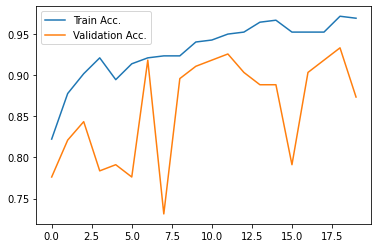

In [21]:
# plotting the accuracy
plt.plot(prototype.history['accuracy'], label='Train Acc.')
plt.plot(prototype.history['val_accuracy'], label='Validation Acc.')
plt.legend()
plt.show()

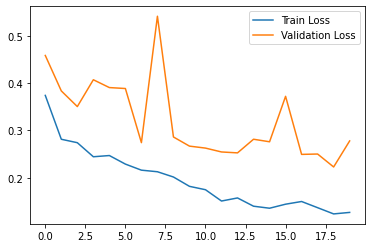

In [22]:
# plotting the loss
plt.plot(prototype.history['loss'], label='Train Loss')
plt.plot(prototype.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [27]:
# saving it as h5 file
from tensorflow.keras.models import load_model
model.save('vgg19_model.h5')

In [30]:
model = load_model('vgg19_model.h5')

In [31]:
y_pred = model.predict(test_set)

In [32]:
y_pred

array([[9.97751892e-01, 2.24807276e-03],
       [7.55338520e-02, 9.24466193e-01],
       [9.87379789e-01, 1.26201585e-02],
       [9.81466472e-02, 9.01853383e-01],
       [1.02937836e-02, 9.89706159e-01],
       [6.95771426e-02, 9.30422902e-01],
       [4.65435296e-01, 5.34564734e-01],
       [9.98659372e-01, 1.34064793e-03],
       [9.58160818e-01, 4.18391898e-02],
       [7.50164926e-01, 2.49835059e-01],
       [2.97721148e-01, 7.02278852e-01],
       [2.24382818e-01, 7.75617123e-01],
       [9.99998689e-01, 1.33322010e-06],
       [9.96217191e-01, 3.78286559e-03],
       [2.25698665e-01, 7.74301350e-01],
       [1.77981615e-01, 8.22018385e-01],
       [4.05892283e-01, 5.94107747e-01],
       [9.26466882e-01, 7.35331252e-02],
       [9.91030335e-01, 8.96962546e-03],
       [9.92662311e-01, 7.33764609e-03],
       [1.94750190e-01, 8.05249810e-01],
       [6.58549309e-01, 3.41450602e-01],
       [5.61600089e-01, 4.38399851e-01],
       [5.61170578e-01, 4.38829452e-01],
       [1.112969

In [33]:
y_pred = np.argmax(y_pred, axis=1)

In [34]:
y_pred

array([0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0,
       1, 0], dtype=int64)

In [36]:
img = image.load_img('Dataset/Test/Uninfected/2.png',target_size=(224,224))

In [46]:
a = image.img_to_array(img)
a

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)

In [47]:
a.shape

(224, 224, 3)

In [48]:
a = a/255

In [49]:
a = np.expand_dims(a, axis=0)
b = preprocess_input(a)
b.shape

(1, 224, 224, 3)

In [50]:
model.predict(b)

array([[4.6033753e-04, 9.9953973e-01]], dtype=float32)

In [53]:
c = np.argmax(model.predict(b))

In [54]:
if c==1:
    print('Uninfected')
else:
    print('Infected')

Uninfected
